In [80]:
import pandas as pd
import numpy as np
import os

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    """
    Identifica evento de calor extremo:
    - Temperatura máxima > 35°C OU Heat Index > 40°C.
    Critérios baseados em estudos de saúde pública e limites de desconforto térmico.
    """
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    """
    Identifica evento de frio extremo:
    - Temperatura mínima < -3°C OU Wind Chill < -5°C.
    Representa frio desconfortável e risco de saúde em ambientes abertos.
    """
    return row['mintempC'] < -3 or row['WindChillC'] < -5

def is_rain_extreme(row):
    """
    Identifica chuva extrema:
    - Precipitação diária > 20 mm.
    Limite comum para alagamentos/localizados e desconforto.
    """
    return row['precipMM'] > 20

def is_snow_extreme(row):
    """
    Identifica presença de neve:
    - Qualquer valor positivo já é evento extremo em Portugal continental.
    """
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    """
    Identifica radiação UV extrema:
    - Índice UV >= 8 (OMS: muito alto).
    """
    return row['uvIndex'] >= 8

# === FUNÇÕES AUXILIARES ===
def assign_season(month):
    """
    Atribui estação do ano a partir do mês:
    12, 1, 2 = Inverno | 3, 4, 5 = Primavera | 6, 7, 8 = Verão | 9, 10, 11 = Outono
    """
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

def classify_city_index(score):
    """
    Converte score numérico em faixa qualitativa:
    Limites baseados em índices internacionais como o TCI.
    """
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === CÁLCULO DO TCI - Tourism Climate Index ===
def compute_tci_monthly(df):
    """
    Calcula o Tourism Climate Index (TCI) original de Mieczkowski (1985) por mês.
    Fórmula: TCI = 2·CID + 2·CIA + 0.5·P + 0.5·S + W
    - CID: Índice de conforto diário (temp. média e UR média)
    - CIA: Índice de conforto de amplitude diária (temp. máxima e UR máxima)
    - P: Precipitação no mês (quanto menos, melhor)
    - S: Insolação média diária no mês (horas de sol)
    - W: Vento médio no mês (quanto mais ameno, melhor)
    Cada componente recebe pontos de 0 (ruim) a 10 (ideal), ponderados na fórmula.
    """
    df['month'] = df['date_time'].dt.month
    tci_list = []
    for (year, month), dfg in df.groupby([df['date_time'].dt.year, 'month']):
        # ---- CID: conforto diário (temp média)
        tmean = dfg['tempC'].mean()
        rhmean = dfg['humidity'].mean()
        if 20 <= tmean <= 27:
            cid = 10
        elif 16 <= tmean < 20 or 27 < tmean <= 30:
            cid = 7
        elif 13 <= tmean < 16 or 30 < tmean <= 33:
            cid = 5
        elif 10 <= tmean < 13 or 33 < tmean <= 36:
            cid = 3
        else:
            cid = 0
        if rhmean > 90 or rhmean < 30:
            cid -= 1

        # ---- CIA: conforto amplitude diária (temp máxima)
        tmax = dfg['maxtempC'].mean()
        rhmax = dfg['humidity'].mean()  # Simplificação, pois normalmente seria UR máxima do mês
        if 20 <= tmax <= 27:
            cia = 10
        elif 16 <= tmax < 20 or 27 < tmax <= 30:
            cia = 7
        elif 13 <= tmax < 16 or 30 < tmax <= 33:
            cia = 5
        elif 10 <= tmax < 13 or 33 < tmax <= 36:
            cia = 3
        else:
            cia = 0
        if rhmax > 90 or rhmax < 30:
            cia -= 1

        # ---- P: índice de precipitação do mês
        p = dfg['precipMM'].sum()
        if p <= 30:
            pi = 10
        elif p <= 60:
            pi = 7
        elif p <= 90:
            pi = 5
        elif p <= 120:
            pi = 3
        else:
            pi = 0

        # ---- S: insolação média diária
        s = dfg['sunHour'].mean()
        if s >= 9:
            si = 10
        elif s >= 7:
            si = 7
        elif s >= 5:
            si = 5
        elif s >= 3:
            si = 3
        else:
            si = 0

        # ---- W: vento médio no mês
        w = dfg['windspeedKmph'].mean()
        if w < 15:
            wi = 10
        elif w < 25:
            wi = 7
        elif w < 35:
            wi = 5
        elif w < 45:
            wi = 3
        else:
            wi = 0

        # ---- Cálculo final do TCI do mês ----
        tci = 2*cid + 2*cia + 0.5*pi + 0.5*si + wi
        tci = max(0, min(100, tci))  # Garante que o índice fique entre 0 e 100
        tci_list.append({'ano': year, 'mes': month, 'tci': tci})

    tci_df = pd.DataFrame(tci_list)
    tci_annual = tci_df['tci'].mean() if not tci_df.empty else np.nan
    return tci_annual, tci_df  # Retorna média anual e valores mensais

# === PROCESSAMENTO DE UMA CIDADE ===
def process_city(df_city):
    """
    Processa uma cidade:
    - Remove dias extremos para cálculo do clima médio
    - Conta quantidade de extremos
    - Calcula score de conforto customizado e amplitude térmica anual
    - Calcula o TCI clássico anual e tabela mensal
    """
    # Identifica dias extremos
    mask_extreme = (
        df_city.apply(is_hot_extreme, axis=1) |
        df_city.apply(is_cold_extreme, axis=1) |
        df_city.apply(is_rain_extreme, axis=1) |
        df_city.apply(is_snow_extreme, axis=1)
    )
    # Contagem dos eventos extremos
    eventos = {
        'calor_extremo': df_city.apply(is_hot_extreme, axis=1).sum(),
        'frio_extremo': df_city.apply(is_cold_extreme, axis=1).sum(),
        'chuva_extrema': df_city.apply(is_rain_extreme, axis=1).sum(),
        'neve': df_city.apply(is_snow_extreme, axis=1).sum(),
        'uv_extremo': df_city.apply(is_uv_extreme, axis=1).sum(),
    }
    # Remove extremos para cálculo do "clima típico"
    df_no_extremes = df_city[~mask_extreme]
    medias = df_no_extremes[['maxtempC','mintempC','FeelsLikeC','humidity','precipMM','sunHour','uvIndex']].mean().to_dict()

    # Score de conforto customizado (simples, ponderado)
    comfort_temp = (df_no_extremes['FeelsLikeC'].between(8,29)).mean()
    comfort_hum = (df_no_extremes['humidity'].between(30,80)).mean()
    comfort_sun = (df_no_extremes['sunHour'] >= 5).mean()
    comfort_precip = (df_no_extremes['precipMM'] <= 20).mean()
    hot_days = (df_no_extremes['maxtempC'] > 30).sum()
    cold_days = (df_no_extremes['mintempC'] < 0).sum()
    rainy_days = (df_no_extremes['precipMM'] > 20).sum()
    # Se quiser incluir vento:
    # comfort_wind = (df_no_extremes['windspeedKmph'] <= 30).mean()

    #score = 100*(0.35*comfort_temp + 0.2*comfort_hum + 0.2*comfort_sun + 0.2*comfort_precip + 0.05*comfort_wind)
    score = 100*(0.4*comfort_temp + 0.2*comfort_hum + 0.2*comfort_sun + 0.2*comfort_precip)
    score -= (hot_days + 0.4*rainy_days + 0.5*cold_days)
    score = max(score,0)
    classificacao = classify_city_index(score)

    # Amplitude térmica anual (diferença entre maior máxima e menor mínima)
    if not df_no_extremes.empty:
        amp_term = df_no_extremes['maxtempC'].max() - df_no_extremes['mintempC'].min()
    else:
        amp_term = np.nan

    # TCI clássico anual e tabela mensal
    tci_annual, tci_monthly = compute_tci_monthly(df_no_extremes)

    return {**medias, **eventos, 'score':score, 'classificacao':classificacao,
            'amplitude_termica': amp_term, 'tci': tci_annual, 'tci_mensal': tci_monthly}

# === PROCESSAMENTO POR ESTAÇÃO DO ANO ===
def process_by_season(df_city):
    """
    Processa uma cidade por estação:
    - Calcula score e indicadores para cada estação (Inverno, Primavera, Verão, Outono)
    - Útil para saber qual estação é mais confortável/localmente ideal
    """
    df_city = df_city.copy()
    df_city['season'] = df_city['date_time'].dt.month.apply(assign_season)
    res = {}
    for season, dfg in df_city.groupby('season'):
        res[season] = process_city(dfg)
    return res

# === LEITURA DE MÚLTIPLOS CSVs DE UMA PASTA ===
def load_weather_data(folder_path, min_days=365):
    """
    Carrega arquivos CSV de clima e filtra apenas os que possuem histórico mínimo de dias.
    Mostra arquivos que foram descartados por não atingir o mínimo.
    """
    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            # Conta número de dias distintos
            num_dias = df['date_time'].nunique()
            # OU, se preferir por período de datas:
            periodo = df['date_time'].max() - df['date_time'].min()
            
            # Filtro: mantém só cidades com histórico >= min_days
            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def formatar_numericos(df):
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df


In [81]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [82]:
# === EXECUÇÃO PRINCIPAL DO RANKING ===
results = []
for location, df_city in df.groupby('municipio'):
    geral = process_city(df_city)
    sazonal = process_by_season(df_city)

    # Identifica a melhor estação do ano (maior score entre as estações)
    melhor_estacao = None
    melhor_score = -np.inf
    for estacao in ['Inverno','Primavera','Verão','Outono']:
        est_score = sazonal.get(estacao,{}).get('score',None)
        if est_score is not None and est_score > melhor_score:
            melhor_estacao = estacao
            melhor_score = est_score

    # Salva os resultados gerais e por estação
    result = {'location': location, **geral, 'melhor_estacao': melhor_estacao, 'melhor_estacao_score': melhor_score}
    for season in ['Inverno','Primavera','Verão','Outono']:
        if season in sazonal:
            for k, v in sazonal[season].items():
                result[f'{season}_{k}'] = v
    results.append(result)

# Cria DataFrame final com o ranking
ranking = pd.DataFrame(results)
ranking = ranking.sort_values('score', ascending=False).reset_index(drop=True)

# Mostra o ranking principal, com TCI, amplitude térmica e melhor estação do ano
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 'melhor_estacao', 'melhor_estacao_score',
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo']])

C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3073239145.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3073239145.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3073239145.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

                 location      score classificacao        tci  \
0              Santa Cruz  93.932584     Excelente  51.000000   
1                 Machico  93.932584     Excelente  51.000000   
2             Porto Santo  92.307692     Excelente  49.230769   
3                   Sines  91.104816     Excelente  45.961538   
4                Grandola  91.104816     Excelente  45.961538   
..                    ...        ...           ...        ...   
304             sao paulo  22.113772      Marginal  47.153846   
305  Macedo de Cavaleiros  18.866097      Marginal  41.192308   
306              Braganca  18.866097      Marginal  41.192308   
307               Vinhais  18.809117      Marginal  41.192308   
308                  Avis   2.709366      Marginal  48.423077   

     amplitude_termica melhor_estacao  melhor_estacao_score  calor_extremo  \
0                   18          Verão             95.053763              0   
1                   18          Verão             95.053763    

C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3073239145.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3073239145.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month


In [84]:
# Função para formatar colunas numéricas
ranking_formatado = formatar_numericos(ranking)

In [86]:
# Você pode salvar em CSV:
filePathRanking = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_clima_portugal.csv'
ranking_formatado.to_csv(filePathRanking, index=False)

In [87]:
print("\nRanking completo (todas as cidades, ordenadas por clima):")
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo', 'melhor_estacao']])



Ranking completo (todas as cidades, ordenadas por clima):
                 location  score classificacao    tci amplitude_termica  \
0              Santa Cruz  93,93     Excelente  51,00             18,00   
1                 Machico  93,93     Excelente  51,00             18,00   
2             Porto Santo  92,31     Excelente  49,23             11,00   
3                   Sines  91,10     Excelente  45,96             23,00   
4                Grandola  91,10     Excelente  45,96             23,00   
..                    ...    ...           ...    ...               ...   
304             sao paulo  22,11      Marginal  47,15             30,00   
305  Macedo de Cavaleiros  18,87      Marginal  41,19             37,00   
306              Braganca  18,87      Marginal  41,19             37,00   
307               Vinhais  18,81      Marginal  41,19             37,00   
308                  Avis   2,71      Marginal  48,42             36,00   

    calor_extremo frio_extremo chuva_ext

In [53]:
print("Top 10 cidades pelo score geral (clima mais agradável):")
print(ranking_formatado[['location', 'score', 'classificacao']].head(10))

Top 10 cidades pelo score geral (clima mais agradável):
            location   score classificacao
0      sao paulo.csv  100,00     Excelente
1        Porto Santo   67,27           Bom
2               Faro   54,60     Aceitável
3           Grandola   52,51     Aceitável
4  Santiago do Cacem   52,51     Aceitável
5              Sines   52,51     Aceitável
6              Lagos   51,79     Aceitável
7          Albufeira   50,76     Aceitável
8              Olhao   50,41     Aceitável
9      Vila do Bispo   50,22     Aceitável


In [88]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)


In [91]:
# Padroniza nomes para garantir o merge
ranking_formatado['location_merge'] = ranking['location'].str.lower().str.strip()
geo['Cidades_merge'] = geo['Cidades'].str.lower().str.strip()

# Junta pelo nome da cidade padronizado
ranking_geo = pd.merge(
    ranking,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

# Seleciona só as 10 melhores cidades pelo score
top10 = ranking_geo.sort_values('score', ascending=False).head(20)

In [68]:
!pip install geopandas

     -------------------------------------- 338.4/338.4 kB 1.0 MB/s eta 0:00:00
     --------------------------------------- 19.2/19.2 MB 23.4 MB/s eta 0:00:00
     --------------------------------------- 11.3/11.3 MB 21.8 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 36.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'G:\\WpSystem\\S-1-5-21-557544600-257252663-2853016040-1001\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\~andas\\_libs\\algos.cp311-win_amd64.pyd'
Check the permissions.



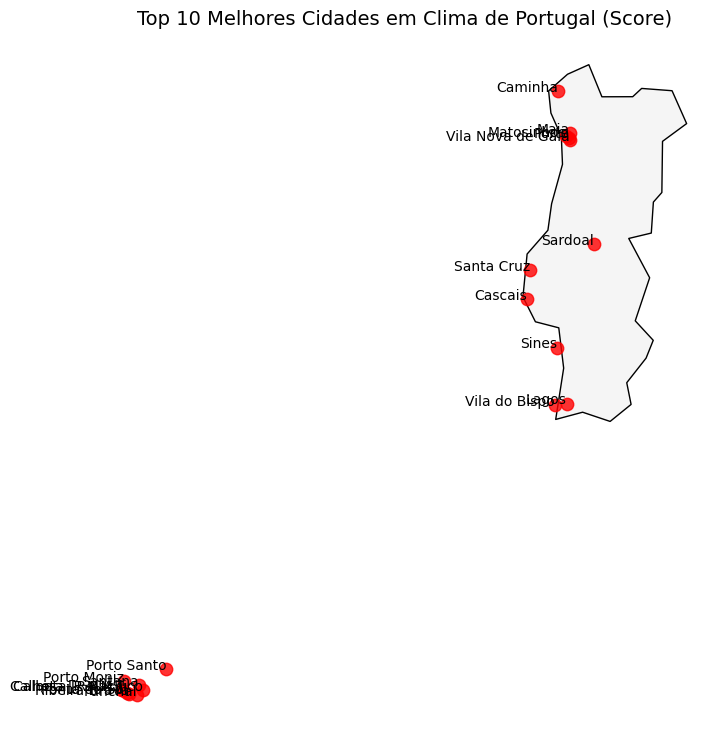

In [92]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Caminho para o arquivo shapefile (.shp)
shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Admin 0 – Countries\\ne_110m_admin_0_countries.shp'

# Carrega o shapefile
portugal = gpd.read_file(shapefile_path)
portugal = portugal[portugal['NAME'] == 'Portugal']  # Coluna pode ser 'NAME' ou 'name' dependendo do shape

# Cria GeoDataFrame das cidades
gdf = gpd.GeoDataFrame(
    top10,
    geometry=gpd.points_from_xy(top10['longitude'], top10['latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(8,10))
portugal.plot(ax=ax, color='whitesmoke', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=80, alpha=0.8)

# Adiciona o nome das cidades
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['location']):
    ax.text(x, y, label, fontsize=10, ha='right')

plt.title('Top 10 Melhores Cidades em Clima de Portugal (Score)', fontsize=14)
plt.axis('off')
plt.show()


In [78]:
print(ranking_formatado.columns)
print(ranking_formatado.isnull().sum())

Index(['location', 'maxtempC', 'mintempC', 'FeelsLikeC', 'humidity',
       'precipMM', 'sunHour', 'uvIndex', 'calor_extremo', 'frio_extremo',
       'chuva_extrema', 'neve', 'uv_extremo', 'score', 'classificacao',
       'amplitude_termica', 'tci', 'tci_mensal', 'melhor_estacao',
       'melhor_estacao_score', 'Inverno_maxtempC', 'Inverno_mintempC',
       'Inverno_FeelsLikeC', 'Inverno_humidity', 'Inverno_precipMM',
       'Inverno_sunHour', 'Inverno_uvIndex', 'Inverno_calor_extremo',
       'Inverno_frio_extremo', 'Inverno_chuva_extrema', 'Inverno_neve',
       'Inverno_uv_extremo', 'Inverno_score', 'Inverno_classificacao',
       'Inverno_amplitude_termica', 'Inverno_tci', 'Inverno_tci_mensal',
       'Primavera_maxtempC', 'Primavera_mintempC', 'Primavera_FeelsLikeC',
       'Primavera_humidity', 'Primavera_precipMM', 'Primavera_sunHour',
       'Primavera_uvIndex', 'Primavera_calor_extremo',
       'Primavera_frio_extremo', 'Primavera_chuva_extrema', 'Primavera_neve',
       'Prim